# Machine Learning Evaluation on Augmented Datasets
This notebook evaluates the impact of data augmentation methods on detecting Low-Rate DDoS (label: 'DDoS-SlowLoris').  
Each ML model is trained as a binary classifier (SlowLoris vs. others) with **10% stratified sampling** per original label.

In [16]:
# 1. Import libraries and define datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Augmented dataset files
aug_files = {
    'SMOTE': 'augmented_data_smote_full.csv',
    'ADASYN': 'augmented_data_adasyn_full.csv',
    'CVAE': 'augmented_data_cvae_full.csv',
    'GAN': 'augmented_data_gan_full.csv'
}

# Feature columns
full_columns = [
    'flow_duration','Header_Length','Protocol Type','Duration','Rate','Srate','Drate',
    'fin_flag_number','syn_flag_number','rst_flag_number','psh_flag_number','ack_flag_number',
    'ece_flag_number','cwr_flag_number','ack_count','syn_count','fin_count','urg_count','rst_count',
    'HTTP','HTTPS','DNS','Telnet','SMTP','SSH','IRC','TCP','UDP','DHCP','ARP','ICMP','IPv','LLC',
    'Tot sum','Min','Max','AVG','Std','Tot size','IAT','Number','Magnitue','Radius',
    'Covariance','Variance','Weight','label'
]
feature_columns = full_columns[:-1]

target_label = 'DDoS-SlowLoris'

sns.set(style='whitegrid')
metrics_list = []  # global storage for results


In [17]:
# 2. Define ML models as binary classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

models = {
    'MLP': MLPClassifier(random_state=42, max_iter=500),
    'SVM': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=500),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


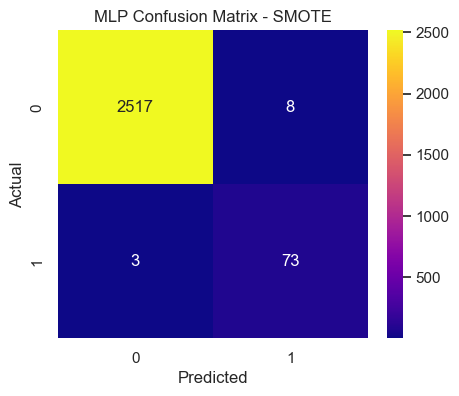

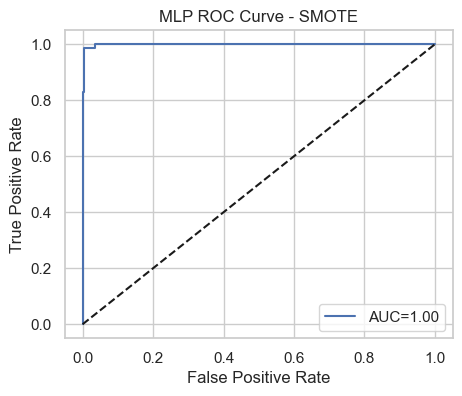

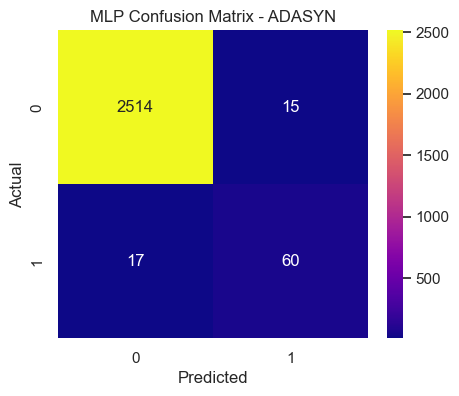

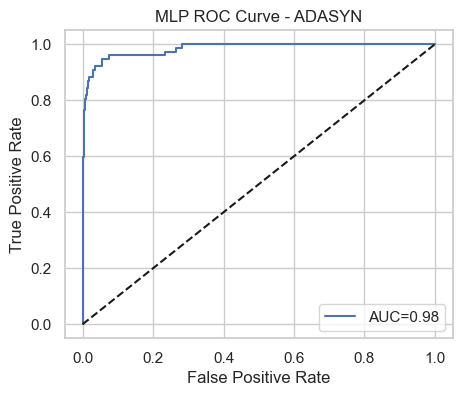

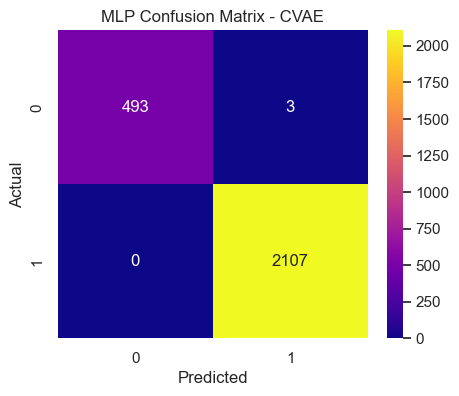

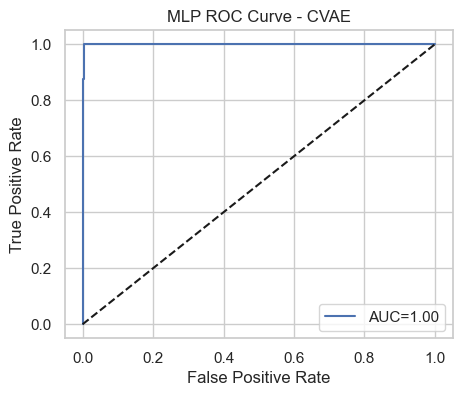

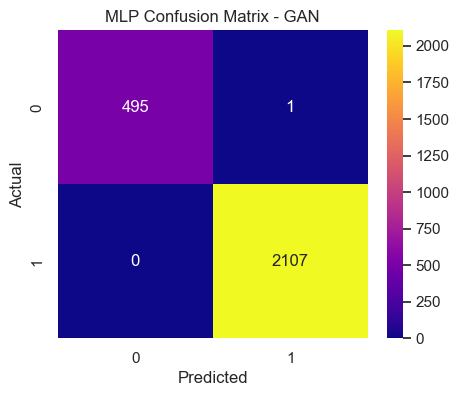

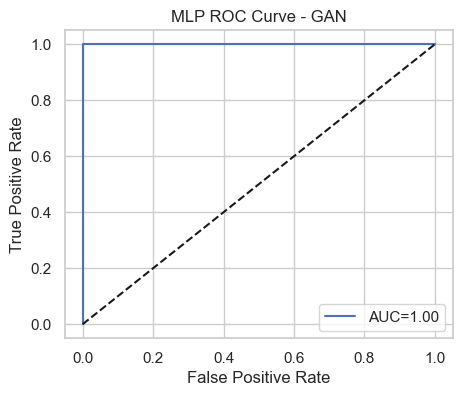

              Accuracy  Precision    Recall  F1-score
Augmentation                                         
SMOTE         0.995771   0.901235  0.960526  0.929936
ADASYN        0.987721   0.800000  0.779221  0.789474
CVAE          0.998847   0.998578  1.000000  0.999289
GAN           0.999616   0.999526  1.000000  0.999763


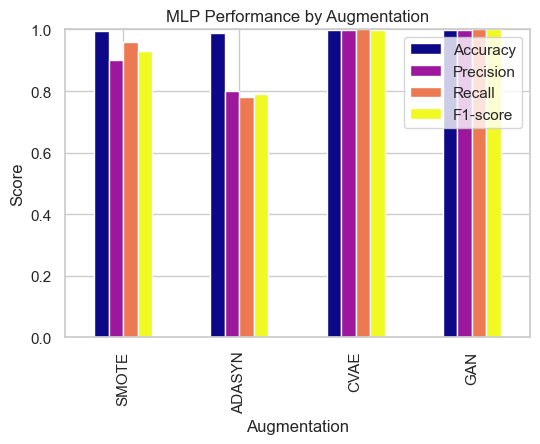

In [18]:
# 3. Evaluate MLP model
model = models['MLP']
results = []

for method, file in aug_files.items():
    # Load CSV and sample 10% per original label
    df = pd.read_csv(file)
    df_sample = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=0.001, random_state=42)
    )
    X = df_sample[feature_columns].values
    # Binarize labels: SlowLoris vs others
    y = (df_sample['label'] == target_label).astype(int).values

    # Train-test split and standardization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Augmentation': method, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
    plt.title(f'MLP Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve plot
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'MLP ROC Curve - {method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Create DataFrame of metrics and bar chart
df_metrics = pd.DataFrame(results).set_index('Augmentation')
print(df_metrics)
df_metrics.plot.bar(colormap='plasma', figsize=(6,4))
plt.title(f'MLP Performance by Augmentation')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Append model results to global list
for r in results:
    r['Model'] = 'MLP'
    metrics_list.append(r)


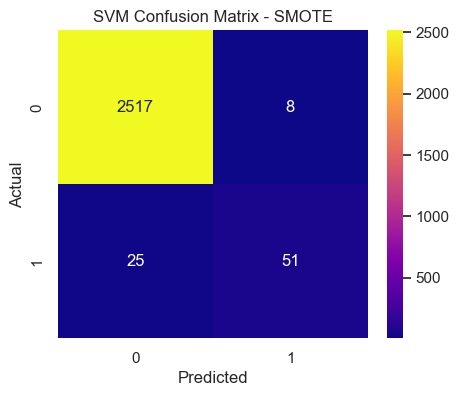

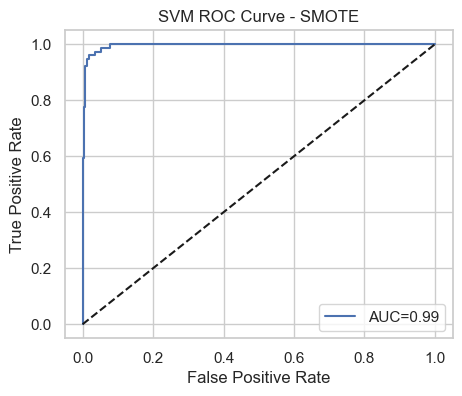

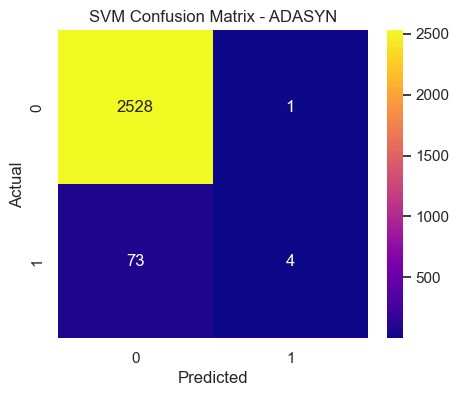

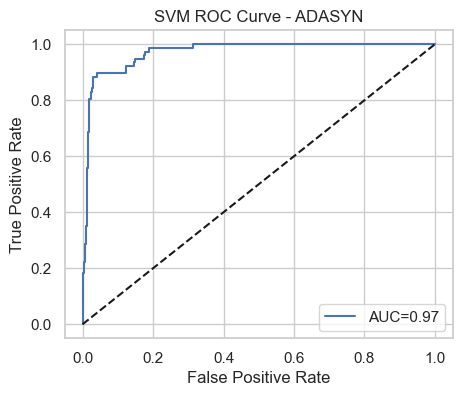

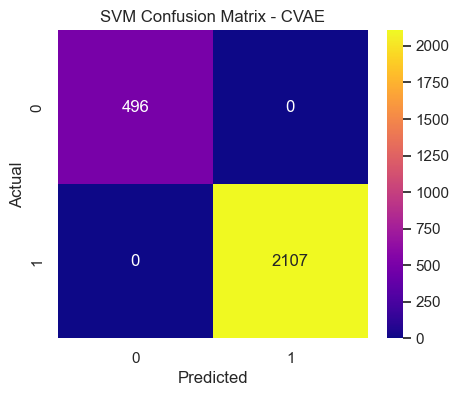

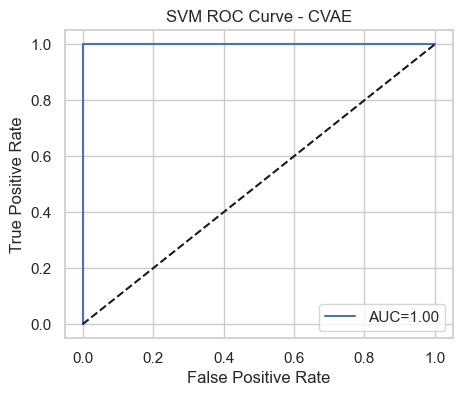

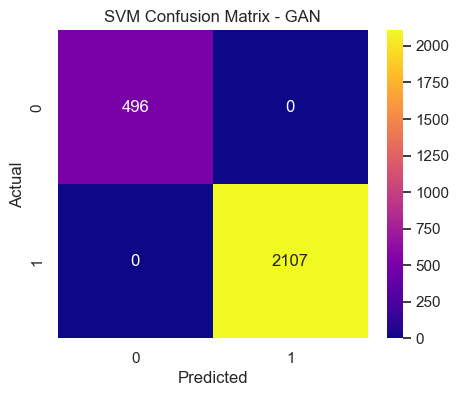

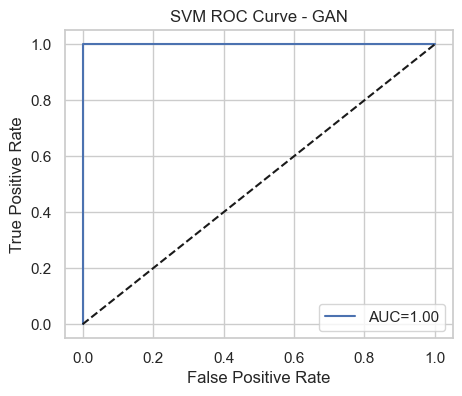

              Accuracy  Precision    Recall  F1-score
Augmentation                                         
SMOTE         0.987313   0.864407  0.671053  0.755556
ADASYN        0.971604   0.800000  0.051948  0.097561
CVAE          1.000000   1.000000  1.000000  1.000000
GAN           1.000000   1.000000  1.000000  1.000000


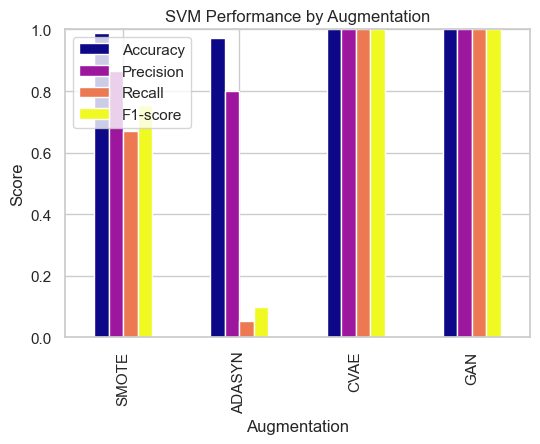

In [19]:
# 3. Evaluate SVM model
model = models['SVM']
results = []

for method, file in aug_files.items():
    # Load CSV and sample 10% per original label
    df = pd.read_csv(file)
    df_sample = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=0.001, random_state=42)
    )
    X = df_sample[feature_columns].values
    # Binarize labels: SlowLoris vs others
    y = (df_sample['label'] == target_label).astype(int).values

    # Train-test split and standardization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Augmentation': method, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
    plt.title(f'SVM Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve plot
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'SVM ROC Curve - {method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Create DataFrame of metrics and bar chart
df_metrics = pd.DataFrame(results).set_index('Augmentation')
print(df_metrics)
df_metrics.plot.bar(colormap='plasma', figsize=(6,4))
plt.title(f'SVM Performance by Augmentation')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Append model results to global list
for r in results:
    r['Model'] = 'SVM'
    metrics_list.append(r)


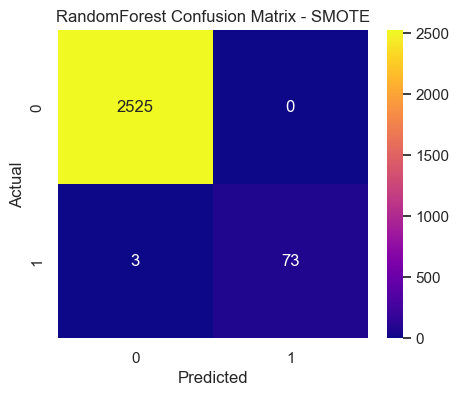

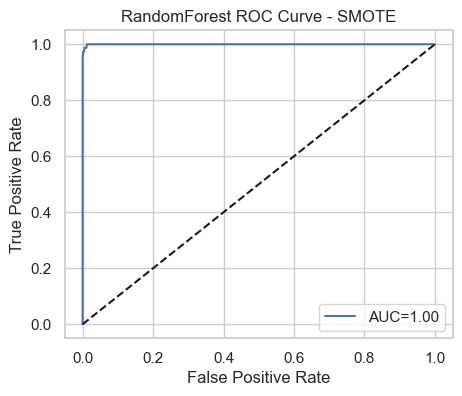

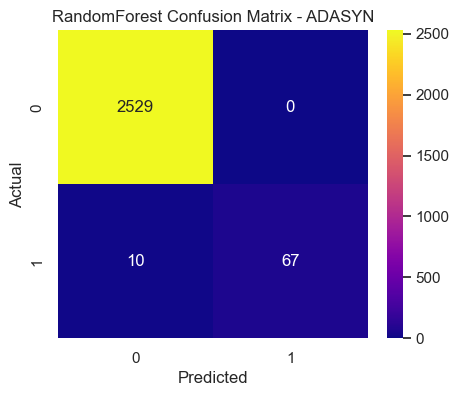

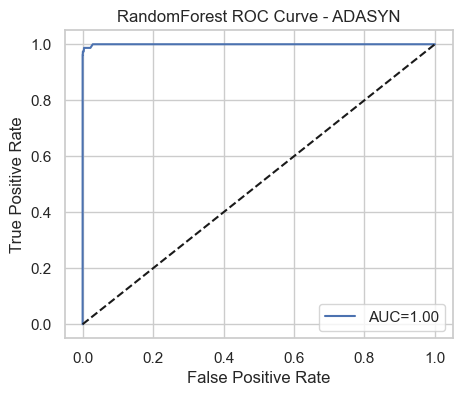

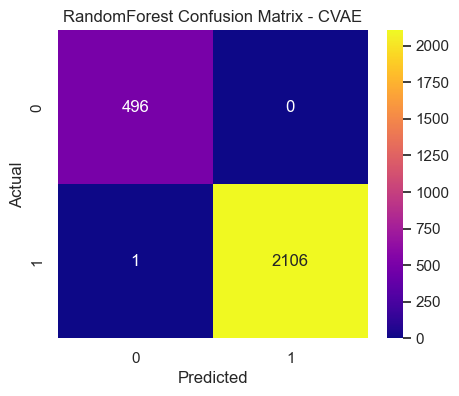

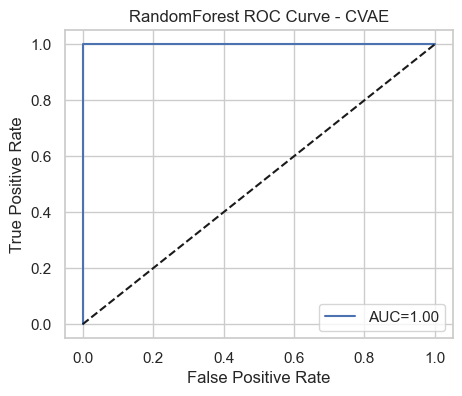

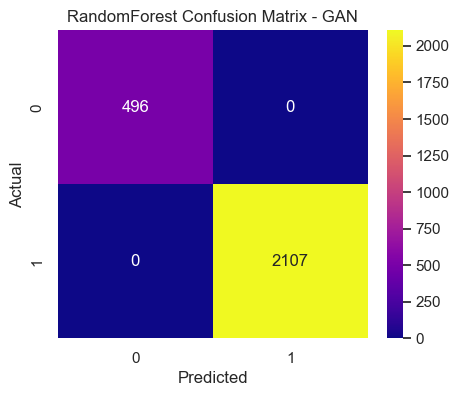

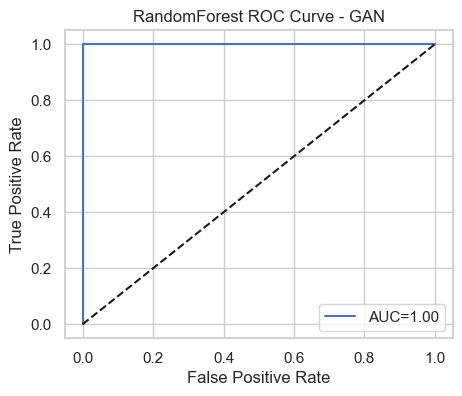

              Accuracy  Precision    Recall  F1-score
Augmentation                                         
SMOTE         0.998847        1.0  0.960526  0.979866
ADASYN        0.996163        1.0  0.870130  0.930556
CVAE          0.999616        1.0  0.999525  0.999763
GAN           1.000000        1.0  1.000000  1.000000


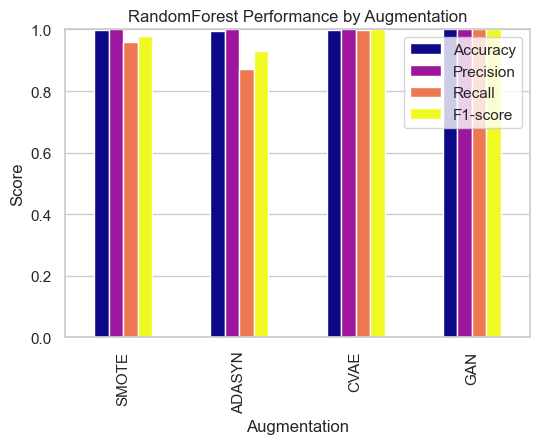

In [20]:
# 3. Evaluate RandomForest model
model = models['RandomForest']
results = []

for method, file in aug_files.items():
    # Load CSV and sample 10% per original label
    df = pd.read_csv(file)
    df_sample = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=0.001, random_state=42)
    )
    X = df_sample[feature_columns].values
    # Binarize labels: SlowLoris vs others
    y = (df_sample['label'] == target_label).astype(int).values

    # Train-test split and standardization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Augmentation': method, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
    plt.title(f'RandomForest Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve plot
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'RandomForest ROC Curve - {method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Create DataFrame of metrics and bar chart
df_metrics = pd.DataFrame(results).set_index('Augmentation')
print(df_metrics)
df_metrics.plot.bar(colormap='plasma', figsize=(6,4))
plt.title(f'RandomForest Performance by Augmentation')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Append model results to global list
for r in results:
    r['Model'] = 'RandomForest'
    metrics_list.append(r)


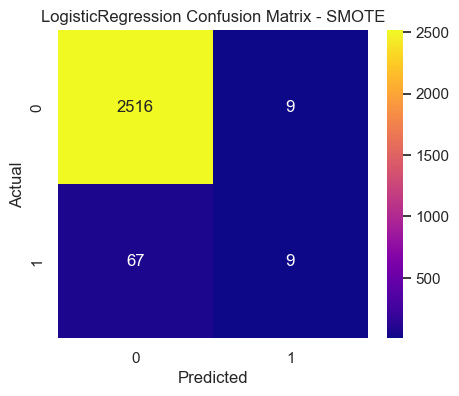

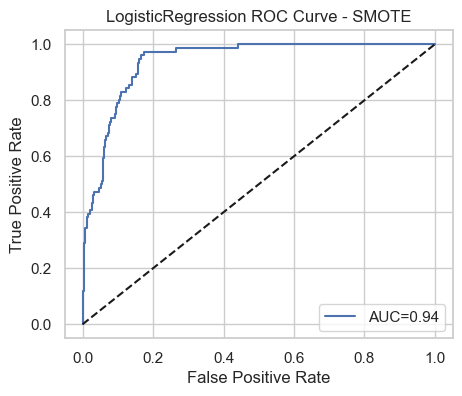

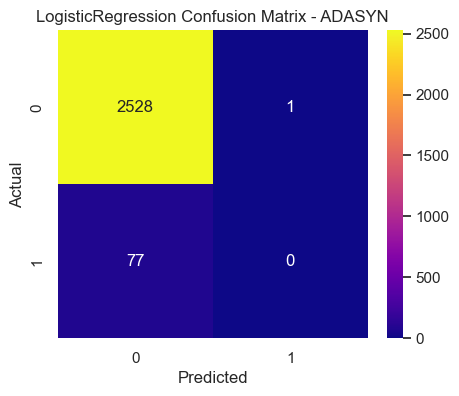

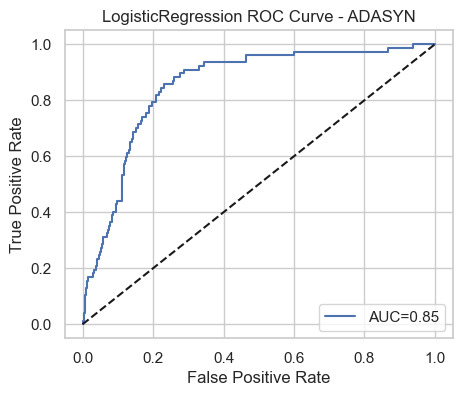

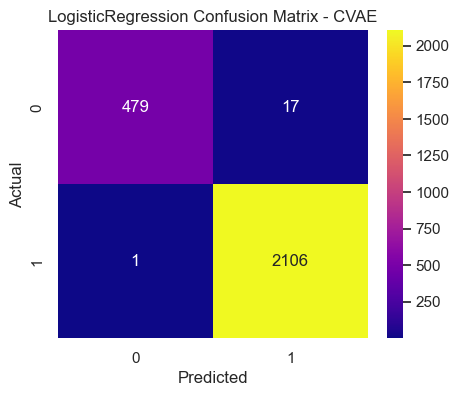

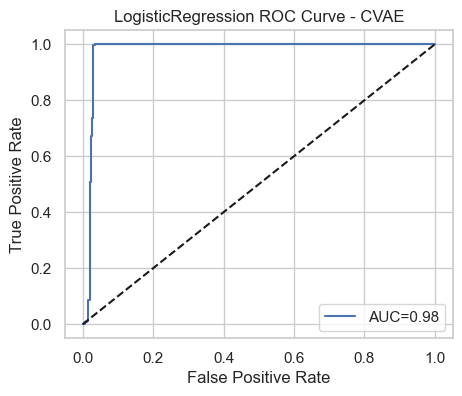

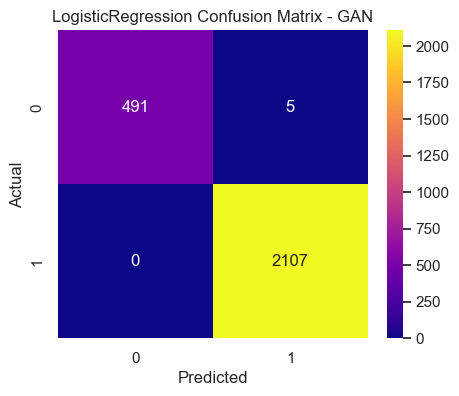

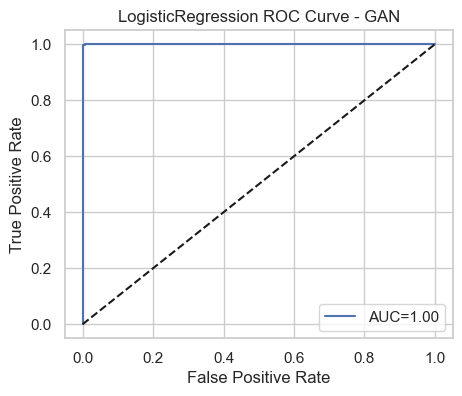

              Accuracy  Precision    Recall  F1-score
Augmentation                                         
SMOTE         0.970780   0.500000  0.118421  0.191489
ADASYN        0.970069   0.000000  0.000000  0.000000
CVAE          0.993085   0.991992  0.999525  0.995745
GAN           0.998079   0.997633  1.000000  0.998815


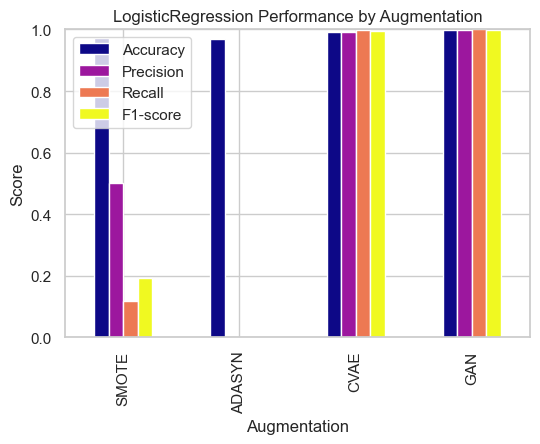

In [21]:
# 3. Evaluate LogisticRegression model
model = models['LogisticRegression']
results = []

for method, file in aug_files.items():
    # Load CSV and sample 10% per original label
    df = pd.read_csv(file)
    df_sample = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=0.001, random_state=42)
    )
    X = df_sample[feature_columns].values
    # Binarize labels: SlowLoris vs others
    y = (df_sample['label'] == target_label).astype(int).values

    # Train-test split and standardization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Augmentation': method, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
    plt.title(f'LogisticRegression Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve plot
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'LogisticRegression ROC Curve - {method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Create DataFrame of metrics and bar chart
df_metrics = pd.DataFrame(results).set_index('Augmentation')
print(df_metrics)
df_metrics.plot.bar(colormap='plasma', figsize=(6,4))
plt.title(f'LogisticRegression Performance by Augmentation')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Append model results to global list
for r in results:
    r['Model'] = 'LogisticRegression'
    metrics_list.append(r)


/Users/eric/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:30:22] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


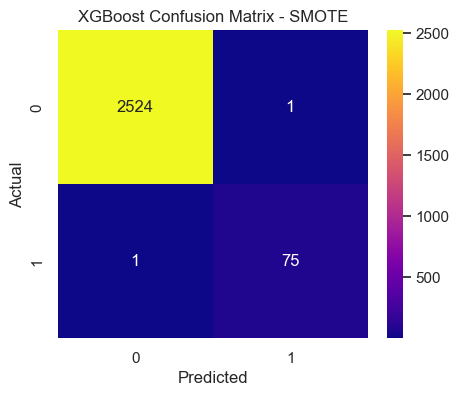

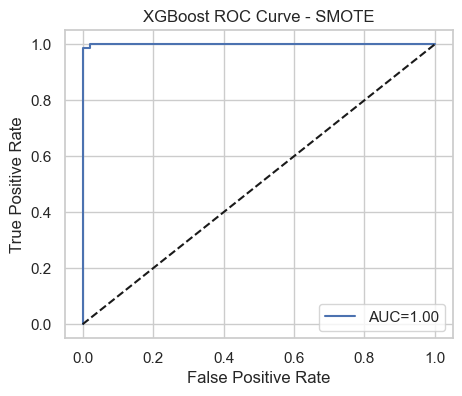

/Users/eric/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:31:03] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


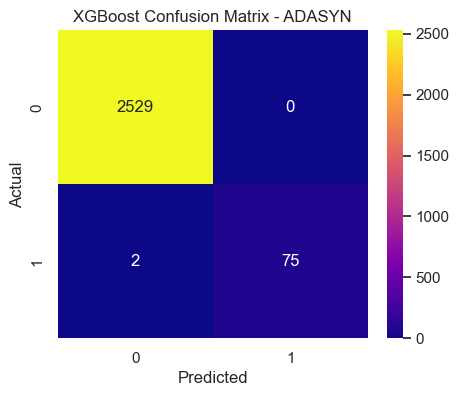

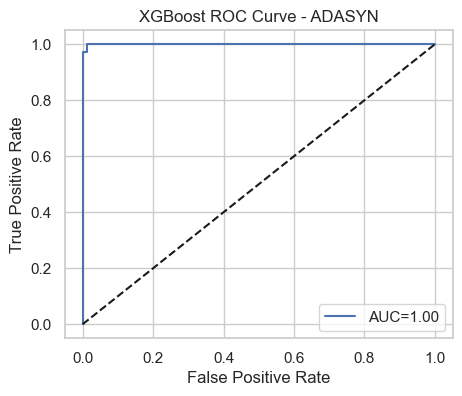

/Users/eric/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:31:47] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


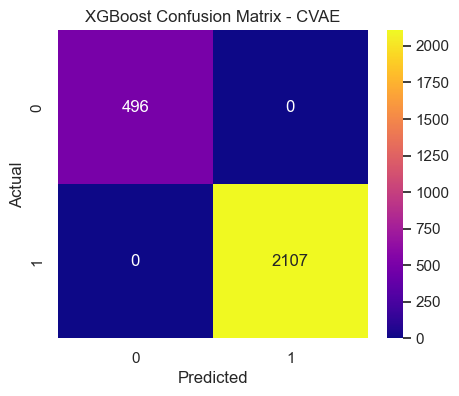

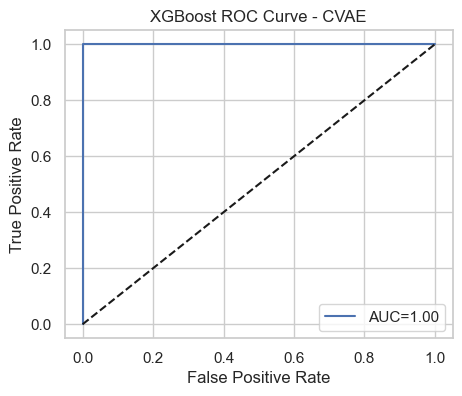

/Users/eric/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:32:33] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


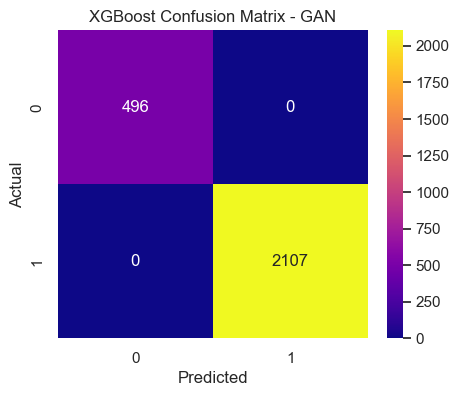

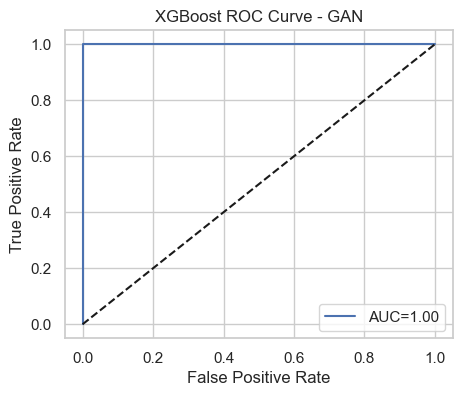

              Accuracy  Precision    Recall  F1-score
Augmentation                                         
SMOTE         0.999231   0.986842  0.986842  0.986842
ADASYN        0.999233   1.000000  0.974026  0.986842
CVAE          1.000000   1.000000  1.000000  1.000000
GAN           1.000000   1.000000  1.000000  1.000000


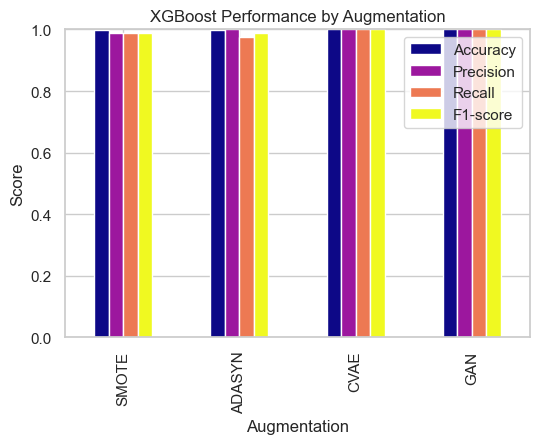

In [22]:
# 3. Evaluate XGBoost model
model = models['XGBoost']
results = []

for method, file in aug_files.items():
    # Load CSV and sample 10% per original label
    df = pd.read_csv(file)
    df_sample = df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(frac=0.001, random_state=42)
    )
    X = df_sample[feature_columns].values
    # Binarize labels: SlowLoris vs others
    y = (df_sample['label'] == target_label).astype(int).values

    # Train-test split and standardization
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute performance metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Augmentation': method, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1})

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='plasma')
    plt.title(f'XGBoost Confusion Matrix - {method}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve plot
    if hasattr(model, 'predict_proba'):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'XGBoost ROC Curve - {method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Create DataFrame of metrics and bar chart
df_metrics = pd.DataFrame(results).set_index('Augmentation')
print(df_metrics)
df_metrics.plot.bar(colormap='plasma', figsize=(6,4))
plt.title(f'XGBoost Performance by Augmentation')
plt.ylabel('Score')
plt.ylim(0,1)
plt.show()

# Append model results to global list
for r in results:
    r['Model'] = 'XGBoost'
    metrics_list.append(r)


## 4. Consolidated Results Across All Models

Augmentation,ADASYN,CVAE,GAN,SMOTE
Model,,,,
LogisticRegression,0.000000,0.995745,0.998815,0.191489
MLP,0.789474,0.999289,0.999763,0.929936
RandomForest,0.930556,0.999763,1.000000,0.979866
SVM,0.097561,1.000000,1.000000,0.755556
XGBoost,0.986842,1.000000,1.000000,0.986842


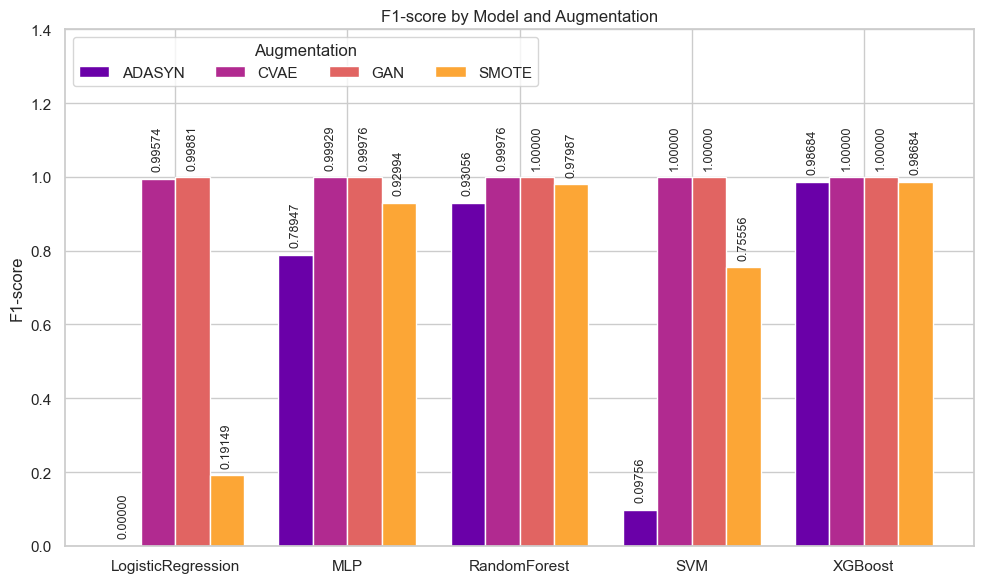

In [39]:
# Consolidated F1‑scores pivoted by Model (rows) and Augmentation (columns)
f1_df = df_all.pivot(index='Model', columns='Augmentation', values='F1-score')
display(f1_df)

# Prepare bar chart: X-axis = ML models, legend = augmentation methods
models = f1_df.index.tolist()
augmentations = f1_df.columns.tolist()
x = np.arange(len(models))
width = 0.2
colors = sns.color_palette("plasma", len(augmentations))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot a group of bars for each augmentation
for i, aug in enumerate(augmentations):
    bars = ax.bar(
        x + i * width,
        f1_df[aug].values,
        width,
        label=aug,
        color=colors[i]
    )
    # Annotate each bar value vertically
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.02,
            f"{bar.get_height():.5f}",
            ha='center',
            va='bottom',
            rotation=90,
            fontsize=9
        )

# Center x‑ticks under grouped bars
ax.set_xticks(x + width * (len(augmentations) - 1) / 2)
ax.set_xticklabels(models)
ax.set_ylabel('F1-score')
ax.set_ylim(0, 1.4)
ax.set_title('F1-score by Model and Augmentation')

# Legend for augmentation methods, arranged horizontally
ax.legend(title='Augmentation', loc='upper left', ncol=len(augmentations))

plt.tight_layout()
plt.show()